# Contact Simulation 

In this assignment, we will get a peek behind how robot dynamics simulators work. As mentioned in slide 14 of the [optimal control and simulation lecture slides](https://scaron.info/robotics-mva/slides/8-optimal-control.pdf), contact simulation (using time-stepping approach) involves three steps that are performed in a loop, namely 1) Collision Detection, 2) Collision Resolution, and 3) Time integration.

This assignment uses the [Coal library](https://github.com/coal-library/coal) (formerly known as HPP-FCL), for performing collision detection, and the integration functions within Pinocchio for the time-stepping. You will implement the collision resolution part to compute the contact impulses to simulate frictional contact. 

The Euler-Lagrange dynamics equations for a manipulator are

$$ M(q) \dot{\nu} + b (q, \nu) = \tau $$

where

$q, M, \nu, b, \text{ and } \tau \text{ are the joint configuration,
joint-space inertia}$ matrix, joint velocity, non-joint and non-constraint torques (due to gravity, centripetal and centrifugal effects) and joint torques respectively.

Let $\Phi (q) \in \mathbb{R}^{3n_c}$ denote the position of the $n_c$ contact points expressed in a frame coincident with the contact point, such that it has a normal component and two tangential components subscripted by $T$ and $N$ respectively. The non-penetration constraint at contact is expresseed as 

$$\Phi(q) \geq 0.$$

The constraint can also be expressed at the velocity level by taking a time derivative on both sides to obtain the constraint

$$ c_N - c_N^* \geq 0, $$

where $c_N = J(q^t)\nu^{t+1} \in \mathbb{R}^{n_c}.$


Expressing the problem at the velocity level using semi-implicit Euler integration scheme, we get

$ M(q^t) \nu^{t+1} = M (q^t) \nu^t + (\tau^t - b(q^t, \nu^t) )\Delta t + J^T \lambda$

where $J$ is the contact Jacobian and $\lambda$ is the contact impulse.


The correct contact impulses, $\lambda^i = \begin{bmatrix} \lambda_{Tx}^i & \lambda_{Ty}^i & \lambda_N^i \end{bmatrix}^T \in \mathbb{R}^3$ for a frictional contact $i$ must satisfy the associated nonlinear complementarity problem (NCP), which arises from three physical principles:

1) **Signorini Condition**: This states that normal contact force should be zero unless in contact and should be non-negative to preclude gluing effect and is mathematically expressed as 
$$ 0 \leq \lambda_N \perp c_N - c_N^* \geq 0.$$

2) **Coulomb friction**: This states that the tangential friction $\Vert \lambda^i_T \Vert \leq \mu^i \lambda^i_N$ 

3) **Maximum dissipation principle**: This states that the frictional forces should maximize the power dissipated. This happens when the frictional force is exactly opposite to the tangential velocity, when there is sliding at the contact $\lambda_T^i = -\mu \lambda_N^i \frac{c_T^i}{\Vert c_T^i \Vert}$, if $\Vert c_T^i \Vert > 0. $

The contact point velocity $c$ is related to the contact forces linearly as follows

$$c = G\lambda + g,$$

where $G = J M^{-1} J^T$ is the Delassus matrix and $g$ is the contact-point velocity if all contact impulses were to be zero. 

## Software instructions

For this assignment, the Pinocchio version installed the course's conda environment is too old. So, we need to create another environment, where we will install Pinocchio and Meshcat. This can be done by running the following lines of code:

```shell
conda create -n robEx5 python=3.10

conda activate robEx5

conda install pinocchio=3.1.0 meshcat-python -c conda-forge

```

In [1]:
import numpy as np
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import meshcat
import matplotlib.pyplot as plt

from tp2.contact_dyn import create_cubes, computeContactProblem
from tp2.visualization import sub_sample

## Ex 5.1 - Implementation of Projected Gauss Seidel

We are going to first implement one of simplest frictional contact resolution approaches: the projected Gauss Seidel algorithm. We will implement a nonlinear version of the algorithm that solves the NCP problem exactly. In practice it has been found to be quite effective despite not having convergence guarantees. For example, it is used by the Bullet simulator to solve the NCP. 

The pseudo-code for the algorithm is given below:

<img src="tp2/PGS_NCP.png" alt="PGS algo" width="700"/>

The PGS contact solver needs to be implemented below with the following API. For simplicity, there is no need to check for convergence. Simply run the solver for a specified number of iterations.

In [ ]:
def solve_contact(
    G: np.ndarray, g: np.ndarray, mus: list, tol: float = 1e-6, max_iter: int = 100
) -> np.ndarray:
    """PGS algorithm solving a contact problem with frictions.

    Args:
        G (np.ndarray): Delassus matrix.
        g (np.ndarray): free velocity of contact points.
        mus (list): list of coefficients of friction for the contact points.
        tol (float, optional): solver tolerance. Defaults to 1e-6.
        max_iter (int, optional): maximum number of iterations for the solver. Defaults to 100.

    Returns:
        np.ndarray: contact impulses.
    """
    nc = len(mus)
    lam = np.zeros(3 * nc)
    for j in range(max_iter):
        for i in range(nc):
            # Indices
            idx_Tx = i * 3
            idx_Ty = i * 3 + 1
            idx_T = slice(idx_Tx, idx_Ty + 1)
            idx_N = i * 3 + 2

            # Normal direction
            c_N = G[idx_N] @ lam + g[idx_N]
            lam_N = lam[idx_N] - c_N / G[idx_N, idx_N]
            lam[idx_N] = max(lam_N, 0.0)

            # Tangential directions
            c_T = G[idx_T] @ lam + g[idx_T]
            min_G_TT = min(G[idx_Tx, idx_Tx], G[idx_Ty, idx_Ty])
            lamb_T = lam[idx_T] - c_T / min_G_TT

            # Projection onto friction cone
            norm_T = np.linalg.norm(lamb_T)
            if norm_T > tol:
                lam[idx_T] = lamb_T * (lam[idx_N] * mus[i] / norm_T)
            else:
                lam[idx_T] = np.zeros(2)

    return lam

### Simulating a cube falling on the floor

We will test the PGS solver for a cube falling on the floor. First we build the Pinocchio model of a cube and a plane (which stands for the floor) and we specify the simulation parameters (time step, contact solver accuracy etc):

In [ ]:
np.random.seed(1234)
pin.seed(12345)

## First example: a cube falling on the floor
cube_dimension = 0.2  # size of cube
cube_mass = 1.0  # mass of cube
mu = 0.5  # friction parameter
eps = 0.0  # elasticity
model, geom_model, visual_model, data, geom_data, visual_data, actuation = create_cubes(
    [cube_dimension], [cube_mass], mu, eps
)  # creating pinocchio models and datas


duration = 1.0  # duration of simulation
dt = 1e-3  # time step duration
T = int(duration / dt)  # number of time steps

tolerance = 1e-6  # contact solver accuracy
max_iter = 100  # maximum number of iterations of the contact solver

Running the simulator for T timesteps.

In [ ]:
# initial state
q0 = model.qinit.copy()
v0 = np.zeros(model.nv)
q0[2] = cube_dimension
rand_place = pin.SE3.Random()
q0[-4:] = pin.SE3ToXYZQUAT(rand_place)[-4:]

q, v = q0.copy(), v0.copy()

qs, vs = [q0], [v0]  # arrays to store trajectory

for t in range(T):  # simulation loop
    tau = np.zeros(model.nv)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del, g, mus = computeContactProblem(
        model, data, geom_model, geom_data, q, v, tau, dt
    )
    if J is not None:
        lam = solve_contact(Del, g, mus, tolerance, max_iter)
        dv = dt * pin.aba(model, data, q, v, tau + J.T @ lam / dt)
        v += dv
    else:
        v = vf
    q = pin.integrate(model, q, v * dt)
    qs += [q]
    vs += [v]

We visualize the simulated trajectory inside the Meshcat visualizer:

In [ ]:
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=False, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [0.8, 0.0, 0.2]  # camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)] * numrep

max_fps = 30.0
fps = min([max_fps, 1.0 / dt])
qs = sub_sample(qs, dt * T, fps)
vs = sub_sample(vs, dt * T, fps)


def get_callback(i: int):
    def _callback(t):
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])

    return _callback

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [6]:
vizer.viewer.jupyter_cell()

In [ ]:
for i in range(numrep):
    vizer.play(qs, 1.0 / fps, get_callback(i))

## II - Implementing CCP solver

The PGS solver is often slow and can require many iterations. Moreover, it lacks convergence guarantees. A common approach taken involves relaxing the original nonlinear complementarity problem to a convex formulation, that results in a conic complementarity problem (CCP). For example, the MuJoCo simulator solves this relaxed problem. MuJoCo differs in another major aspect, where it adds compliance to the contact, which we will not address in this assignment. The convex relaxation causes the Signorini condition to be violated, which means that contact impulses can occur even when breaking contact. 

The optimization problem associated with the CCP is 

$$ \underset{\lambda \in K_\mu}{\mathrm{\textbf{min}}} \, \frac{1}{2} \lambda^T G \lambda + g^T \lambda, $$

where $K_\mu$ corresponds to the second-order cone where the contact forces satisfy the friction cone constraints. 

The projection function for this second-order cone is provided below as a helper function.

In [ ]:
def SOC_projection(lam: np.ndarray, mus: list) -> np.ndarray:
    """Projection of the contact impulses on the friction cone.

    Args:
        lambda (np.ndarray): contact impulses.

    Returns:
        np.ndarray: projected contact impulses.
    """

    nc = lam.shape[0] // 3
    lam_proj = np.zeros(lam.shape)
    for i in range(nc):
        # lam_proj[i*3+2] = np.maximum(0, lam[i*3+2])
        norm = np.linalg.norm(lam[i * 3 : i * 3 + 2])
        if norm > mus[i] * lam[i * 3 + 2]:
            x = norm
            z = lam[i * 3 + 2]
            friction_cone_exterior = np.array([mus[i], 1]) / np.linalg.norm([mus[i], 1])
            projected_point = (
                np.array([x, z]).T @ friction_cone_exterior
            ) * friction_cone_exterior
            if projected_point[1] < 0:
                projected_point *= 0
            lam_proj[i * 3 : i * 3 + 2] = (
                projected_point[0] * lam[i * 3 : i * 3 + 2] / norm
            )
            lam_proj[i * 3 + 2] = projected_point[1]
        else:
            lam_proj[i * 3 : i * 3 + 3] = lam[i * 3 : i * 3 + 3]

    return lam_proj

## Ex 5.2 Implement the CCP solver

Implement a simple Alternating Direction Method of Multipliers (ADMM) algorithm to solve the CCP problem, whose pseudocode is given below. Similarly to the PGS solver, we do not expect you to check for convergence.

<img src="tp2/ADMM_dualCCP.png" alt="ADMM CCP" width="800"/>

where $\rho$ can be interpreted as a quadratic penalty parameter.


In [ ]:
def solve_contact_ADMM_CCP(
    G: np.ndarray, g: np.ndarray, mus: list, rho: float = 1e1, max_iter: int = 100
) -> np.ndarray:
    """ADMM algorithm solving a contact problem with frictions.

    Args:
        G (np.ndarray): Delassus matrix.
        g (np.ndarray): free velocity of contact points.
        mus (list): list of coefficients of friction for the contact points.
        rho (float, optional): ADMM parameter. Defaults to 100..
        max_iter (int, optional): maximum number of iterations for the solver. Defaults to 100.

    Returns:
        np.ndarray: contact impulses.
    """

    G_tilde_inv = np.linalg.inv(G + rho * np.eye(G.shape[0]))

    n = len(mus)
    lam = np.zeros(3 * n)
    z = np.zeros(3 * n)
    gam = np.zeros(3 * n)

    for k in range(max_iter):
        lam = -G_tilde_inv @ (g - rho * z + gam)
        z = SOC_projection(lam + gam / rho, mus)
        gam = gam + rho * (lam - z)

    return lam

Now solve the same cube falling problem using the CCP solver.

In [ ]:
q0 = model.qinit.copy()
v0 = np.zeros(model.nv)
q0[2] = cube_dimension
q0[-4:] = pin.SE3ToXYZQUAT(rand_place)[-4:]

q, v = q0.copy(), v0.copy()

qs, vs = [q0], [v0]  # arrays to store trajectory

for t in range(T):  # simulation loop
    tau = np.zeros(model.nv)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del, g, mus = computeContactProblem(
        model, data, geom_model, geom_data, q, v, tau, dt
    )
    if J is not None:
        lam = solve_contact_ADMM_CCP(Del, g, mus)
        dv = dt * pin.aba(model, data, q, v, tau + J.T @ lam / dt)
        v += dv
    else:
        v = vf
    q = pin.integrate(model, q, v * dt)
    qs += [q]
    vs += [v]

In [ ]:
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=False, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [0.8, 0.0, 0.2]  # camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)] * numrep

max_fps = 30.0
fps = min([max_fps, 1.0 / dt])
qs = sub_sample(qs, dt * T, fps)
vs = sub_sample(vs, dt * T, fps)


def get_callback(i: int):
    def _callback(t):
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])

    return _callback

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [12]:
vizer.viewer.jupyter_cell()

In [ ]:
for i in range(numrep):
    vizer.play(qs, 1.0 / fps, get_callback(i))

## Ex 5.3 Evaluate Signorini constraint violation

Let us now check how well the different formulations satisfy the physics principles. Since we know that the CCP formulation can violate Signorini condition, let us monitor this constraint's residual. Write a function to evaluate the constraint residual of the Signorini condition (repeated below). The output should be $\ell_\infty$ norm of the residual of all the three Signorini constraints over all the contact points.

$$ 0 \leq \lambda_N \perp c_N - c_N^* \geq 0.$$

In [ ]:
def compute_sig_residual(lambda_n: list, c_n: list, c_n_star: list) -> float:
    """Computes the l-inf norm of the residual of the 3 Signorini complementarity constraints.

    The constraints are:
    1) lam_N >= 0
    2) c_N - c_N_star >= 0
    3) lam_N * (c_N - c_N_star) = 0
    """
    n_c = len(lambda_n)
    resid_vec = np.zeros(3 * n_c)
    for i in range(n_c):
        lam_i_N = lambda_n[i]
        c_i_N = c_n[i]
        c_i_N_star = c_n_star[i]
        c_i_diff = c_i_N - c_i_N_star

        resid_vec[i * 3] = np.maximum(0.0, -lam_i_N)
        resid_vec[i * 3 + 1] = np.maximum(0.0, -c_i_diff)
        resid_vec[i * 3 + 2] = np.abs(lam_i_N * c_i_diff)

    return np.linalg.norm(resid_vec, np.inf)

### Cube sliding on the floor

Running both the PGS and the CCP formulations for a problem where the cube is made to slide on the floor by applying a horizontal force the x-direction that is too high for friction forces to counterbalance.

In [ ]:
q0 = model.qinit.copy()
v0 = np.zeros(model.nv)

q, v = q0.copy(), v0.copy()

qs_pgs = np.zeros((7, T))
vs_pgs = np.zeros((6, T))  # arrays to store trajectory

internal_forces = np.zeros(
    (T, 4)
)  # store contact force along x axis for each contact point at every time step
signorini_resids_pgs = []
for t in range(T):  # simulation loop
    tau = np.zeros(model.nv)
    if t < 500:
        tau[0] = 10  # applying an increasing force pushing the cube along y axis
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del, g, mus = computeContactProblem(
        model, data, geom_model, geom_data, q, v, tau, dt
    )
    if J is not None:
        lam = solve_contact(Del, g, mus, tolerance, max_iter)
        dv = dt * pin.aba(model, data, q, v, tau + J.T @ lam / dt)
        v += dv
        for i in range(4):
            internal_forces[t, i] = lam[3 * i] / dt
    else:
        v = vf
    c = J @ v
    signorini_resids_pgs.append(
        compute_sig_residual(lam[2::3].tolist(), c[2::3].tolist(), [0] * len(mus))
    )
    q = pin.integrate(model, q, v * dt)
    qs_pgs[:, t] = q
    vs_pgs[:, t] = v


internal_forces_CCP = np.zeros(
    (T, 4)
)  # store contact force along x axis for each contact point at every time step
vs_pgs_list = [vs_pgs[:, i].T for i in range(T)]
qs_pgs_list = [qs_pgs[:, i].T for i in range(T)]

In [ ]:
# Perform the same simulation using CCP
q0 = model.qinit.copy()
v0 = np.zeros(model.nv)

q, v = q0.copy(), v0.copy()

qs_ccp = np.zeros((7, T))
vs_ccp = np.zeros((6, T))  # arrays to store trajectory
y_vel = []
z_vel = []

signorini_resids_ccp = []

for t in range(T):  # simulation loop
    tau = np.zeros(model.nv)
    if t < 500:
        tau[0] = 10  # applying an increasing force pushing the cube along y axis
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del, g, mus = computeContactProblem(
        model, data, geom_model, geom_data, q, v, tau, dt
    )
    if J is not None:
        lam = solve_contact_ADMM_CCP(Del, g, mus, 1e1)
        dv = dt * pin.aba(model, data, q, v, tau + J.T @ lam / dt)
        v += dv
        # for i in range(4):
        #     internal_forces_CCP[t,i] = lam[3*i]/dt
        c = J @ v
        signorini_resids_ccp.append(
            compute_sig_residual(
                lam[2::3].tolist(), c[2::3].tolist(), [0] * (c.shape[0] // 3)
            )
        )
    else:
        v = vf
        signorini_resids_ccp.append(0)

    q = pin.integrate(model, q, v * dt)
    qs_ccp[:, t] = q
    vs_ccp[:, t] = v

vs_ccp_list = [vs_ccp[:, i].T for i in range(T)]
qs_ccp_list = [qs_ccp[:, i].T for i in range(T)]
len(vs_ccp_list)

1000

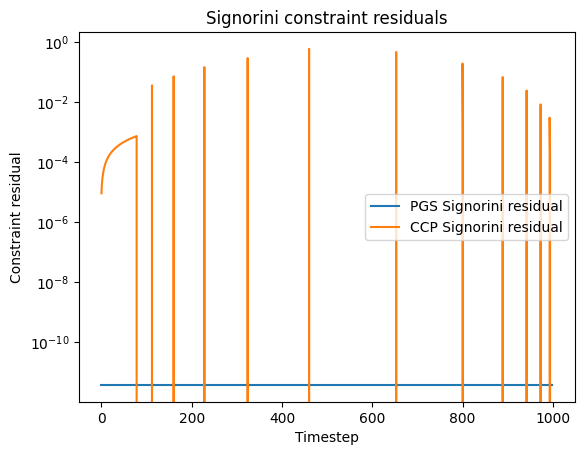

In [ ]:
# Plotting the Signorini complementarity constraint residual for the two solvers
plt.figure()
plt.semilogy(
    [t for t in range(T)], signorini_resids_pgs, label="PGS Signorini residual"
)
plt.semilogy(
    [t for t in range(T)], signorini_resids_ccp, label="CCP Signorini residual"
)
plt.legend()
plt.title("Signorini constraint residuals")
plt.xlabel("Timestep")
plt.ylabel("Constraint residual")
plt.show()

Let us now plot the velocities and positions of the block for both the formulations.

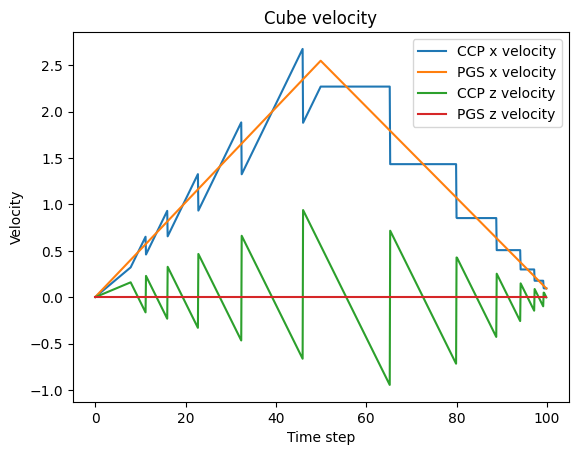

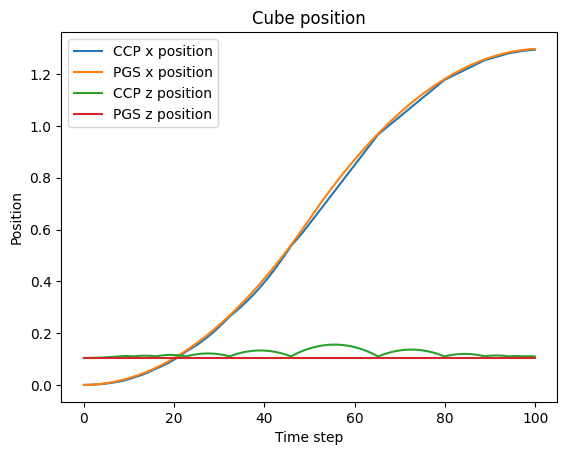

In [ ]:
# plot the motion resulting from the two solvers

plt.figure()
plt.plot([t * 0.1 for t in range(T)], vs_ccp[0, :], label="CCP x velocity")
plt.plot([t * 0.1 for t in range(T)], vs_pgs[0, :], label="PGS x velocity")
plt.plot([t * 0.1 for t in range(T)], vs_ccp[2, :], label="CCP z velocity")
plt.plot([t * 0.1 for t in range(T)], vs_pgs[2, :], label="PGS z velocity")
plt.legend()
plt.title("Cube velocity")
plt.xlabel("Time step")
plt.ylabel("Velocity")
plt.show()

# plotting positions
plt.figure()
plt.plot([t * 0.1 for t in range(T)], qs_ccp[0, :], label="CCP x position")
plt.plot([t * 0.1 for t in range(T)], qs_pgs[0, :], label="PGS x position")
plt.plot([t * 0.1 for t in range(T)], qs_ccp[2, :], label="CCP z position")
plt.plot([t * 0.1 for t in range(T)], qs_pgs[2, :], label="PGS z position")
plt.legend()
plt.title("Cube position")
plt.xlabel("Time step")
plt.ylabel("Position")
plt.show()

### Visualization of the sliding motion

#### PGS formulation

In [ ]:
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=False, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [0.8, 0.0, 0.2]  # camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)] * numrep

max_fps = 30.0
fps = min([max_fps, 1.0 / dt])
qs = sub_sample(qs_pgs_list, dt * T, fps)
vs = sub_sample(vs_pgs_list, dt * T, fps)


def get_callback(i: int):
    def _callback(t):
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])

    return _callback

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [20]:
vizer.viewer.jupyter_cell()

In [ ]:
for i in range(numrep):
    vizer.play(qs, 1.0 / fps, get_callback(i))

#### CCP Formulation

In [ ]:
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=False, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [0.8, 0.0, 0.2]  # camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)] * numrep

max_fps = 30.0
fps = min([max_fps, 1.0 / dt])
qs = sub_sample(qs_ccp_list, dt * T, fps)
vs = sub_sample(vs_ccp_list, dt * T, fps)


def get_callback(i: int):
    def _callback(t):
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])

    return _callback

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [23]:
vizer.viewer.jupyter_cell()

In [ ]:
for i in range(numrep):
    vizer.play(qs, 1.0 / fps, get_callback(i))

### PGS sensitivity to ill-conditioned problems

The PGS algorithm being a Gauss-Seidel method, resolves contact forces on a per-contact basis. This can make the algorithm sensitive to problems where the Delassus matrix is ill-conditioned.

### Simulating two stacked cubes

We define the pinocchio model of 2 cubes of very different mass (1g vs 1e3kg) with a plane (standing for the floor). The ill-conditionning of the problem should hinder the convergence of PGS and cause the simulation to fail.

In [ ]:
cube_dimension = 0.2  # size of cube
cube1_mass = 1e-3  # mass of cube 1
cube2_mass = 1e3  # mass of cube 2
mu = 0.9  # friction parameter between cube and floor
el = 0.0
comp = 0.0
model, geom_model, visual_model, data, geom_data, visual_data, actuation = create_cubes(
    [cube_dimension, cube_dimension], [cube1_mass, cube2_mass], mu, el
)

# Number of time steps
T = 100
dt = 1e-3

# Physical parameters of the contact problem
Kb = 1e-4 * 0.0  # Baumgarte
eps = 0.0  # elasticity

In [ ]:
# initial state
q0 = pin.neutral(model)
q0[2] = cube_dimension / 2 + cube_dimension / 50.0
q0[9] = 3.0 * cube_dimension / 2 + 3 * cube_dimension / 50.0
v0 = np.zeros(model.nv)
q, v = q0.copy(), v0.copy()

qs, vs = [q0], [v0]  # arrays to store trajectory

for t in range(T):  # simulation loop
    tau = np.zeros(model.nv)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del, g, mus = computeContactProblem(
        model, data, geom_model, geom_data, q, v, tau, dt
    )
    if J is not None:
        lam = solve_contact(Del, g, mus, tolerance, max_iter)
        dv = dt * pin.aba(model, data, q, v, tau + J.T @ lam / dt)
        v += dv
    else:
        v = vf
    q = pin.integrate(model, q, v * dt)
    qs += [q]
    vs += [v]

### Visualization

We visualize the trajectory of the 2 stacked cubes:

In [ ]:
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=False, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [0.8, 0.0, 0.2]  # camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)] * numrep

max_fps = 30.0
fps = min([max_fps, 1.0 / dt])
qs = sub_sample(qs, dt * T, fps)
vs = sub_sample(vs, dt * T, fps)


def get_callback(i: int):
    def _callback(t):
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])

    return _callback

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [28]:
vizer.viewer.jupyter_cell()

In [ ]:
for i in range(numrep):
    vizer.play(qs, 1.0 / fps, get_callback(i))

Try the same ill-conditioned cube-stacking with CCP, it should result in better simulation with no interpenetration.

In [ ]:
# initial state
q0 = pin.neutral(model)
q0[2] = cube_dimension / 2 + cube_dimension / 50.0
q0[9] = 3.0 * cube_dimension / 2 + 3 * cube_dimension / 50.0
v0 = np.zeros(model.nv)
q, v = q0.copy(), v0.copy()

qs, vs = [q0], [v0]  # arrays to store trajectory

for t in range(T):  # simulation loop
    tau = np.zeros(model.nv)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del, g, mus = computeContactProblem(
        model, data, geom_model, geom_data, q, v, tau, dt
    )
    if J is not None:
        lam = solve_contact_ADMM_CCP(Del, g, mus, 1e1)
        dv = dt * pin.aba(model, data, q, v, tau + J.T @ lam / dt)
        v += dv
    else:
        v = vf
    q = pin.integrate(model, q, v * dt)
    qs += [q]
    vs += [v]

In [ ]:
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=False, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [0.8, 0.0, 0.2]  # camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)] * numrep

max_fps = 30.0
fps = min([max_fps, 1.0 / dt])
qs = sub_sample(qs, dt * T, fps)
vs = sub_sample(vs, dt * T, fps)


def get_callback(i: int):
    def _callback(t):
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])

    return _callback

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [32]:
vizer.viewer.jupyter_cell()

In [ ]:
for i in range(numrep):
    vizer.play(qs, 1.0 / fps, get_callback(i))

## References

For more information about how the different solvers compare with each other, consult the following reference on which this assignment is based

[1] Quentin Le Lidec, Wilson Jallet, Louis Montaut, Ivan Laptev, Cordelia Schmid, and Justin Carpentier. Contact
Models in Robotics: a Comparative Analysis. IEEE Transactions on Robotics, 2024. doi:10.1109/TRO.2024.3434208, arXiv:2304.06372.


For a recent algorithm that solves the NCP problem associated with frictional contact quite reliably in practice using an ADMM method, refer 

[2] Justin Carpentier, Quentin Le Lidec, and Louis Montaut. From Compliant to Rigid Contact Simulation: a Unified
and Efficient Approach. In Proceedings of Robotics: Science and Systems, Delft, Netherlands, July 2024. doi:
10.15607/RSS.2024.XX.108

Releasing the software implemented in this paper as a fast open-source library C++ library called [Simple](https://github.com/Simple-Robotics/Simple) is a current area of effort.